In [1]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from pathlib import Path

# Load data
project_root = Path.cwd().resolve()
csv_path = project_root.parent / "data" / "creditcard.csv"
if not csv_path.exists():
    csv_path = project_root / "data" / "creditcard.csv"
df = pd.read_csv(csv_path)

X = df.drop("Class", axis=1)
y = df["Class"]

# train-val-test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

In [2]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),
    random_state=42
)
xgb.fit(X_train, y_train)

def entropy(p):
    return -np.sum(p*np.log(p+1e-9), axis=1)

xgb_probs = xgb.predict_proba(X_test)

xgb_acc = accuracy_score(y_test, np.argmax(xgb_probs, axis=1))
xgb_conf = np.mean(np.max(xgb_probs, axis=1))
xgb_ent = np.mean(entropy(xgb_probs))

print("XGB Accuracy:", xgb_acc)
print("XGB Mean Confidence:", xgb_conf)
print("XGB Mean Entropy:", xgb_ent)


XGB Accuracy: 0.9995786664794073
XGB Mean Confidence: 0.99988425
XGB Mean Entropy: 0.00048563242


In [3]:
# Expected Calibration Error (ECE)
def expected_calibration_error(probs, y, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    bins = np.linspace(0,1,n_bins+1)
    ece = 0.0

    for i in range(n_bins):
        idx = (confidences > bins[i]) & (confidences <= bins[i+1])
        if np.sum(idx) == 0:
            continue

        acc = np.mean(predictions[idx] == y.iloc[idx])
        conf = np.mean(confidences[idx])
        ece += np.abs(acc - conf) * np.sum(idx) / len(y)

    return ece

In [4]:
xgb_sig = CalibratedClassifierCV(xgb, method="sigmoid", cv="prefit")
xgb_sig.fit(X_val, y_val)

xgb_iso = CalibratedClassifierCV(xgb, method="isotonic", cv="prefit")
xgb_iso.fit(X_val, y_val)

raw_probs = xgb.predict_proba(X_test)
sig_probs = xgb_sig.predict_proba(X_test)
iso_probs = xgb_iso.predict_proba(X_test)

def summarize(p, name):
    print(name,
          "Conf:", np.mean(np.max(p,1)),
          "Ent:", np.mean(entropy(p)),
          "ECE:", expected_calibration_error(p, y_test.reset_index(drop=True)))

summarize(raw_probs, "Raw XGB")
summarize(sig_probs, "Sig XGB")
summarize(iso_probs, "Iso XGB")

c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Raw XGB Conf: 0.99988425 Ent: 0.00048563242 ECE: 0.00032034869806129576
Sig XGB Conf: 0.9994829497780199 Ent: 0.0038506870555359857 ECE: 0.00013578589169663515
Iso XGB Conf: 0.9994932825140799 Ent: 0.003075058529595899 ECE: 0.00018465427273533074


In [7]:
xgb_results = []

def noise_drift(X, intensity):
    return X + np.random.normal(0, intensity, X.shape)

drift_levels = [0.0, 0.2, 0.5, 1.0]



for d in drift_levels:
    Xd = noise_drift(X_test, d)

    rp = xgb.predict_proba(Xd)
    sp = xgb_sig.predict_proba(Xd)
    ip = xgb_iso.predict_proba(Xd)

    xgb_results.append([
        d,
        accuracy_score(y_test, np.argmax(rp,1)),
        accuracy_score(y_test, np.argmax(sp,1)),
        accuracy_score(y_test, np.argmax(ip,1)),
        np.mean(np.max(rp,1)),
        np.mean(np.max(sp,1)),
        np.mean(np.max(ip,1)),
        np.mean(entropy(rp)),
        np.mean(entropy(sp)),
        np.mean(entropy(ip))
    ])
xgb_results

[[0.0,
  0.9995786664794073,
  0.9995786664794073,
  0.9995611109160493,
  np.float32(0.99988425),
  np.float64(0.9994829497780199),
  np.float64(0.9994932825140799),
  np.float32(0.00048563242),
  np.float64(0.0038506870555359857),
  np.float64(0.003075058529595899)],
 [0.2,
  0.9994908886626171,
  0.9995435553526912,
  0.9994908886626171,
  np.float32(0.99983215),
  np.float64(0.9994861577441441),
  np.float64(0.999381612475922),
  np.float32(0.0006376541),
  np.float64(0.0038796960057545173),
  np.float64(0.003544881908305545)],
 [0.5,
  0.9992451107756047,
  0.9993504441557529,
  0.9992977774656788,
  np.float32(0.9997276),
  np.float64(0.9994602375915431),
  np.float64(0.9991931086371524),
  np.float32(0.0009547888),
  np.float64(0.003932689561488961),
  np.float64(0.0044356755290744536)],
 [1.0,
  0.9990871107053826,
  0.9991397773954567,
  0.9991748885221726,
  np.float32(0.9995297),
  np.float64(0.999453778929968),
  np.float64(0.9986798194172688),
  np.float32(0.0017620102),
 

In [8]:
columns = [
    "drift",
    "raw_acc", "sig_acc", "iso_acc",
    "raw_conf", "sig_conf", "iso_conf",
    "raw_ent", "sig_ent", "iso_ent"
]

xgb_df = pd.DataFrame(xgb_results, columns=columns)
xgb_df.to_csv("xgb_results.csv", index=False)

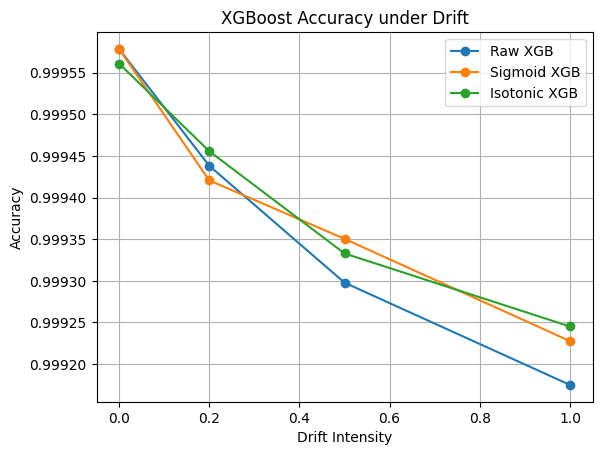

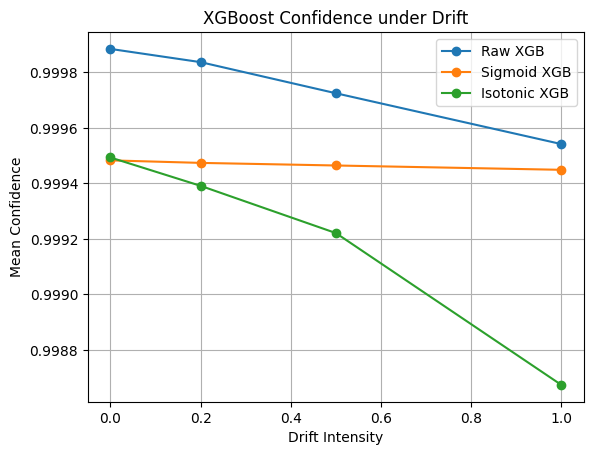

In [6]:
drift = [r[0] for r in xgb_results]

raw_acc = [r[1] for r in xgb_results]
sig_acc = [r[2] for r in xgb_results]
iso_acc = [r[3] for r in xgb_results]

plt.figure()
plt.plot(drift, raw_acc, marker='o')
plt.plot(drift, sig_acc, marker='o')
plt.plot(drift, iso_acc, marker='o')

plt.xlabel("Drift Intensity")
plt.ylabel("Accuracy")
plt.title("XGBoost Accuracy under Drift")
plt.legend(["Raw XGB", "Sigmoid XGB", "Isotonic XGB"])
plt.grid(True)
plt.show()

raw_conf = [r[4] for r in xgb_results]
sig_conf = [r[5] for r in xgb_results]
iso_conf = [r[6] for r in xgb_results]

plt.figure()
plt.plot(drift, raw_conf, marker='o')
plt.plot(drift, sig_conf, marker='o')
plt.plot(drift, iso_conf, marker='o')

plt.xlabel("Drift Intensity")
plt.ylabel("Mean Confidence")
plt.title("XGBoost Confidence under Drift")
plt.legend(["Raw XGB", "Sigmoid XGB", "Isotonic XGB"])
plt.grid(True)
plt.show()
